In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from math import *
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
train = pd.read_csv('train.csv')
dev = pd.read_csv('dev.csv')
test = pd.read_csv('test.csv')

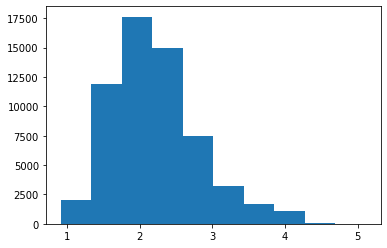

In [3]:
plt.hist(list(map(log,train.fare_amount)))
#plt.hist(list(map(log,list(map(log,train.fare_amount)))))
plt.show()

In [4]:
def r(x):
    return round(x,3)
def distance(x):
    lon1,lat1,lon2,lat2  = x[0],x[1],x[2],x[3]
    lon1 = radians(float(lon1))
    lon2 = radians(float(lon2))
    lat1 = radians(float(lat1))
    lat2 = radians(float(lat2))

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371
    return (c * r)
def dist_sq(x):
    return distance(x)*distance(x)


def features_train(train):
    train.pickup_longitude = list(map(r,train.pickup_longitude))
    train.pickup_latitude = list(map(r,train.pickup_latitude))
    train.dropoff_longitude = list(map(r,train.dropoff_longitude))
    train.dropoff_latitude = list(map(r,train.dropoff_latitude))
#     train.fare_amount = list(map(log,list(map(log,train.fare_amount))))
    train.fare_amount = list(map(log,train.fare_amount))

    train['dt'] = train.pickup_datetime.apply(lambda t: datetime.strptime(t[:-4],"%Y-%m-%d %H:%M:%S").timestamp())
    train['year'] = train.pickup_datetime.apply(lambda t: datetime.strptime(t[:-4],"%Y-%m-%d %H:%M:%S").year)
    train['weekday'] = train.pickup_datetime.apply(lambda t: datetime.strptime(t[:-4], "%Y-%m-%d %H:%M:%S").weekday())
    train['hour'] = train.pickup_datetime.apply(lambda t: datetime.strptime(t[:-4], "%Y-%m-%d %H:%M:%S").hour)
    train['month'] = train.pickup_datetime.apply(lambda t: datetime.strptime(t[:-4], "%Y-%m-%d %H:%M:%S").month)
    train['distance'] = list(map(distance,train.iloc[:,[1,2,3,4]].values))
    train['distance_sq'] = list(map(dist_sq,train.iloc[:,[1,2,3,4]].values))

    train['bias'] = np.ones([np.shape(train)[0],1])

    phi = train[['bias','pickup_longitude', 'pickup_latitude','distance_sq',
           'dropoff_longitude', 'dropoff_latitude',
            'dt', 'year', 'distance']] # , 'weekday', 'hour', 'month', 'passenger_count'
    y = train['fare_amount']
    
    return [phi,y]

def features_test(train):

    train.pickup_longitude = list(map(r,train.pickup_longitude))
    train.pickup_latitude = list(map(r,train.pickup_latitude))
    train.dropoff_longitude = list(map(r,train.dropoff_longitude))
    train.dropoff_latitude = list(map(r,train.dropoff_latitude))

    train['dt'] = train.pickup_datetime.apply(lambda t: datetime.strptime(t[:-4],"%Y-%m-%d %H:%M:%S").timestamp())
    train['year'] = train.pickup_datetime.apply(lambda t: datetime.strptime(t[:-4],"%Y-%m-%d %H:%M:%S").year)
    train['weekday'] = train.pickup_datetime.apply(lambda t: datetime.strptime(t[:-4], "%Y-%m-%d %H:%M:%S").weekday())
    train['hour'] = train.pickup_datetime.apply(lambda t: datetime.strptime(t[:-4], "%Y-%m-%d %H:%M:%S").hour)
    train['month'] = train.pickup_datetime.apply(lambda t: datetime.strptime(t[:-4], "%Y-%m-%d %H:%M:%S").month)
    train['distance'] = list(map(distance,train.iloc[:,[1,2,3,4]].values))
    train['distance_sq'] = list(map(dist_sq,train.iloc[:,[1,2,3,4]].values))
    train['bias'] = np.ones([np.shape(train)[0],1])

    phi = train[['bias','pickup_longitude', 'pickup_latitude','distance_sq',
           'dropoff_longitude', 'dropoff_latitude', 
            'dt', 'year', 'distance']] #, 'weekday', 'hour', 'month','passenger_count'
    return phi

In [28]:
def gradL_mse(phi, w, y):
    a = pd.DataFrame(np.dot(phi.T, phi))
    b = pd.DataFrame(np.dot(phi.T, y))
    c = pd.DataFrame(np.dot(a, w))
    return 2*(c - b)

def compute_RMSE(phi, w, y):
    error = (np.array(y).reshape(np.shape(y)[0],1)- np.dot(phi, w))
    return np.linalg.norm(error)

def generate_output(phi_test, w):
    yp = np.matmul(phi_test, w)
    return yp

def closed_soln(phi, y):
    return np.linalg.pinv(phi).dot(y)

def gradient_descent(phi, y):
    n = phi.shape[1]
    lr = 0.000006
    w = np.random.rand(n, 1)
    w = pd.DataFrame(w)
    while np.linalg.norm(gradL_mse(phi, w, y)) > 0.01:
        w = w - lr * gradL_mse(phi, w, y)
    return w

def sgd(phi, y):
    n = phi.shape[1]
    lr = 0.00001
    w = np.random.rand(n, 1)
    phi = phi.to_numpy()
    y = y.to_numpy()
    while True:
        i = np.random.randint(phi.shape[0], size=1)
        grad = np.matmul(np.transpose(phi[i, :]), np.matmul(phi[i, :], w) - y[i])
        w = w - lr * grad
        # print(np.linalg.norm(grad))
        if np.linalg.norm(grad) < 0.00001:
            return w
def pnorm(phi, y, p):
    n = phi.shape[1]
    lr = 0.000001
    w = np.ones(n)
    w = pd.DataFrame(w)
    lda = 15
    while np.linalg.norm(gradL_mse(phi, w, y) + p * lda * np.power(w, p - 1)) > 0.00001:
        w = w - lr * (gradL_mse(phi, w, y) + p * lda * np.power(w, p - 1))
        print(w)
        print(np.linalg.norm(gradL_mse(phi, w, y) + p * lda * np.power(w, p - 1)))
    return w

In [6]:
phi_train,y_train = features_train(train)
phi_dev,y_dev = features_train(dev)
phi_test = features_test(test)

for i in range(1,np.shape(phi_train)[1]):
    phi_train.iloc[:, i] = (phi_train.iloc[:, i] - np.mean(phi_train.iloc[:, i])) / np.std(phi_train.iloc[:, i])

for i in range(1,np.shape(phi_dev)[1]):
    phi_dev.iloc[:, i] = (phi_dev.iloc[:, i] - np.mean(phi_dev.iloc[:, i])) / np.std(phi_dev.iloc[:, i])
    
for i in range(1,np.shape(phi_test)[1]):
    phi_test.iloc[:, i] = (phi_test.iloc[:, i] - np.mean(phi_test.iloc[:, i])) / np.std(phi_test.iloc[:, i])

/home/harsh/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/harsh/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [7]:
import pickle
try : 
    w_b1 = pickle.load(open("w_b1.p", "rb"))
except :
    w_b1 = pnorm(phi_train, y_train, 2)
    pickle.dump(w_b1, open("w_b1.p", "wb"))

In [8]:
w_b1

,0
0,2.216847
1,0.018588
2,-0.024095
3,-0.376453
4,0.031042
5,-0.035681
6,0.149717
7,-0.067719
8,0.615182


In [32]:
rmse = compute_RMSE(phi_dev[:20000], w_b1, y_dev[:20000])
print(rmse)
y = generate_output(phi_test.to_numpy(), w_b1.to_numpy())
np.savetxt('./sub.csv', y, delimiter=",")

53.94496544467879
